# General Plotting Function

## Load Libraries

In [5]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import numpy.ma as ma
import numpy.linalg as la
import pandas as pd
import xarray as xr
xr.set_options(keep_attrs=True)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.patches as patch
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature
import time
from functools import wraps
import pyxpcm
from pyxpcm.models import pcm
import run_throughs.sithom_plot_style as sps
import run_through_gmm as rtg
print('xarray', xr.__version__)
print('matplotlib', matplotlib.__version__)

xarray 0.15.1
matplotlib 3.2.2


In [3]:
def _return_name(K, pca):

    return "nc/i-metric-joint-k-" + str(K) + "-d-" + str(pca)


def _return_plot_folder(K, pca):
    folder = "../FBSO-Report/images/i-metric-joint-k-" + str(K) + "-d-" + str(pca) + "/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    return folder


def _return_folder(K, pca):

    folder = _return_name(K, pca) + "/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    return folder


def _return_pair_name(K, pca):
    return "nc/pair-i-metric-k-" + str(K) + "-d-" + str(pca)


def _return_pair_folder(K, pca):
    folder = "nc/pair-i-metric-k-" + str(K) + "-d-" + str(pca) + "/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    return folder

## Helper Plot Functions

In [4]:
def southern_ocean_axes_setup(ax, fig):
    carree = ccrs.PlateCarree()
    ax.set_extent([-180, 180, -90, -30], carree)
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)

    def plot_boundary():
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.45
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

    plot_boundary()

In [121]:
def label_subplots(axs, start_from=0, fontsize=13):
    if isinstance(axs, list):
        axs = np.asarray(axs)

    orig_label_list = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M"]
    assert len(axs.ravel()) + start_from <= len(orig_label_list)
    subset_labels = []
    for i in range(len(axs.ravel())):
        subset_labels.append(orig_label_list[i + start_from])
    for i, label in enumerate(subset_labels):
        print(i, label)
        axs.ravel()[i].text(
            0.02,
            0.95,
            str("(" + label.lower() + ")"),
            color="black",
            transform=axs.ravel()[i].transAxes,
            fontsize=fontsize,
            fontweight="bold",
            va="top",
        )

## Separate plots

In [170]:
def sep_plots(da_list, var_list):

    map_proj = ccrs.SouthPolarStereo()
    carree = ccrs.PlateCarree()

    fig = plt.figure()

    num_da = len(da_list)

    fig, axes = plt.subplots(1, num_da, subplot_kw={"projection": map_proj})

    for i in range(num_da):
        southern_ocean_axes_setup(axes[i], fig)
        #sps.ds_for_graphing(da_list[i].to_dataset()).to_array().plot(
        da_list[i].plot(
            transform=carree,  # the data's projection
            ax=axes[i],
            subplot_kws={"projection": map_proj},  # the plot's projection
            cbar_kwargs={
                "shrink": 0.8,
                "label": var_list[i],
                "orientation": "horizontal",  # xr_da.name
                "pad": 0.01
            },
        )
        axes[i].coastlines()
        axes[i].set_title("")
        
    label_subplots(axes)

## Plot many on one axes

In [47]:
def plot_on_one(da):
    carree = ccrs.PlateCarree()
    map_proj = ccrs.SouthPolarStereo()
    pairs = da.coords["pair"].values.shape[0]

    gs = GridSpec(
        nrows=2,
        ncols=pairs,
        width_ratios=[1 / pairs for x in range(pairs)],
        height_ratios=[1, 0.05],
        wspace=0.15,
    )

    fig = plt.gcf()

    ax1 = fig.add_subplot(gs[0, :], projection=map_proj)
    cbar_axes = [fig.add_subplot(gs[1, i]) for i in range(pairs)]

    southern_ocean_axes_setup(ax1, fig)
    cmap_list = sps.return_list_of_colormaps(pairs, fade_to_white=False)
    
    for i in range(pairs):
        im = da.isel(pair=i).plot(
            cmap=cmap_list[i],
            vmin=0,
            vmax=1,
            ax=ax1,
            add_colorbar=False,
            transform=carree,
            subplot_kws={"projection": map_proj},
        )
        cbar = plt.colorbar(
            im, cax=cbar_axes[i], orientation="horizontal", ticks=[0, 1]
        )
        cbar.set_label(da.coords["pair"].values[i])
    plt.suptitle("")
    plt.title("")
    ax1.set_title("")
    ax1.coastlines()

## Translate_i_metric

In [144]:
# @jit(nopython=True)
def go_through_with_numba(cart_prod, i_metric, sorted_version, threshold):
    if True:
        pair_i_metric_list = []

        pair_list = []
        
        for pair in cart_prod:
            print("pair", pair)
            """pair [0 1] pair [0 2] pair [0 3] 
               pair [1 2] pair [1 3] pair [2 3]"""
            temp_list = for_loops_with_numba(pair, i_metric, sorted_version, threshold)
            if temp_list[2] == True:
                pair_list.append(temp_list[0])
                pair_i_metric_list.append(temp_list[1])
            # time, YC, XC
            # shape (60, 2, 588, 2160)
    print("pair_list", pair_list)
        
    return pair_i_metric_list, pair_list

#@jit(nopython=True)
def for_loops_with_numba(pair, i_metric, sorted_version, threshold):
    shape = np.shape(sorted_version)
    print("shape", shape)
    # shape (60, 2, 588, 2160)
    at_least_one_point = False
    # float32 changed from np.zeros
    pair_i_metric = np.zeros([shape[0], shape[2], shape[3]]#, dtype='float64'
                            )
    pair_i_metric[:, :, :] = np.nan
    for i in range(shape[0]):  # 60
        for j in range(shape[2]):  # 588
            for k in range(shape[3]):  # 2160
                if np.array_equal(pair, sorted_version[i, :, j, k]):
                    # sorted_version (60, 2, 588, 2160)
                    if i_metric[i, j, k] >= threshold:
                        # i_metric (60, 588, 2160)
                        pair_i_metric[i, j, k] = i_metric[i, j, k]
                        at_least_one_point = True
    return [pair, pair_i_metric, at_least_one_point]


def pair_i_metric(ds, threshold=0.05):
    
    print("ds.A_B.values.shape", ds.A_B.values.shape)

    sorted_version = np.sort(ds.A_B.values, axis=1)
    print("sorted_version.shape", sorted_version.shape)
    # sorted_version (60, 2, 588, 2160)

    i_metric = ds.IMETRIC.isel(Imetric=0).values

    print("i_metric", i_metric.shape)
    # i_metric (60, 588, 2160)

    list_no = [i for i in range(int(np.nanmax(sorted_version)) + 1)]

    print("list_no", list_no)

    # list_no [0, 1, 2, 3]

    cart_prod = [
        np.array([a, b]) for a in list_no for b in list_no if a <= b and a != b
    ]     
    # [array([0, 1]), array([0, 2]), array([0, 3]), array([1, 2]), array([1, 3]), array([2, 3])]

    print("cart_prod", cart_prod)

    pair_i_metric_list, pair_list = go_through_with_numba(
        cart_prod, i_metric, sorted_version, threshold
    )
    
    print("pair_i_metric_list", pair_i_metric_list)
    print("pair_i_metric_list len", len(pair_i_metric_list))
    print("pair_list", pair_list)
    print("pair_list len", len(pair_list))
    
    shape = np.shape(sorted_version)
    # shape (60, 2, 588, 2160)

    pair_i_metric_array = np.zeros(
        [len(pair_i_metric_list), shape[0], shape[2], shape[3]]
    )

    for i in range(len(pair_i_metric_list)):

        pair_i_metric_array[i, :, :, :] = pair_i_metric_list[i][:, :, :]

    pair_str_list = []

    for i in range(len(pair_list)):
        pair_str_list.append(
            str(pair_list[i][0] + 1) + " to " + str(pair_list[i][1] + 1)
        )

    da = xr.DataArray(
        pair_i_metric_array,
        dims=["pair", "time", "YC", "XC"],
        coords={
            "XC": ds.coords["XC"].values,
            "YC": ds.coords["YC"].values,
            "time": ds.coords["time"].values,
            "pair": pair_str_list,
        },
    )

    return da


In [154]:
for K in [2]:
    ds = xr.open_dataset("~/pyxpcm/nc/i-metric-joint-k-" + str(K) + "-d-3.nc")
    new_da = pair_i_metric(ds, threshold=0.01)
    new_da.to_netcdf("pair_i_metric_k_"+ str(K) +".nc")

ds.A_B.values.shape (60, 2, 588, 2160)
sorted_version.shape (60, 2, 588, 2160)
i_metric (60, 588, 2160)
list_no [0, 1]
cart_prod [array([0, 1])]
pair [0 1]
shape (60, 2, 588, 2160)
pair_list [array([0, 1])]
pair_i_metric_list [array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [146]:
ls

Gen-Plot-Func.ipynb   meta.yaml             readthedocs.yml
HOW_TO_RELEASE        nc/                   requirements.txt
LICENSE.txt           old/                  run_through_gmm.py
README.md             old-ipynb/            run_throughs/
__pycache__/          pair_i_metric_k_4.nc  setup.py
docs/                 pc-check.ipynb        translate_nc.py
i_metric.py           plot_i_metric.py      web/
interp.nc             pyxpcm/


## Load datasets

In [4]:
ds = xr.open_dataset("/Volumes/BSOSE-DISC/pyxpcm/nc/i-metric-joint-k-5-d-3.nc")

In [7]:
ds.coords

Coordinates:
  * XC       (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float64 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * time     (time) datetime64[ns] 2008-01-31T10:24:00 ... 2012-12-31

In [11]:
ds.A_B.__str__()

"<xarray.DataArray 'A_B' (time: 60, rank: 2, YC: 588, XC: 2160)>\n[152409600 values with dtype=float64]\nCoordinates:\n  * XC       (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9\n  * YC       (YC) float64 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72\n  * time     (time) datetime64[ns] 2008-01-31T10:24:00 ... 2012-12-31\nDimensions without coordinates: rank\nAttributes:\n    long_name:  Top Two Clusters\n    units:      \n    valid_min:  0\n    valid_max:  5"

In [12]:
ds.Imetric.__str__()

"<xarray.DataArray 'Imetric' (Imetric: 1)>\narray([0])\nDimensions without coordinates: Imetric"

In [17]:
ds.IMETRIC.__str__()

"<xarray.DataArray 'IMETRIC' (time: 60, Imetric: 1, YC: 588, XC: 2160)>\n[76204800 values with dtype=float64]\nCoordinates:\n  * XC       (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9\n  * YC       (YC) float64 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72\n  * time     (time) datetime64[ns] 2008-01-31T10:24:00 ... 2012-12-31\nDimensions without coordinates: Imetric\nAttributes:\n    long_name:  I metric\n    units:      \n    valid_min:  0\n    valid_max:  1"

## Load Data

In [186]:
def run_through_plot(K=5, pca=3, save_nc=False):

    # link_to_netcdf = rtg._return_name(K, pca) + '.nc'
    # ds = xr.open_dataset(link_to_netcdf)
    # print(ds.__str__())

    batch_size = 2

    for i in range(40, 42, batch_size):
        print("running", i)
        if save_nc:
            da = tnc.pair_i_metric(
                ds.isel(time=slice(i, i + batch_size)), threshold=0.05
            )
        if save_nc:
            da.rename("pair_i_metric").to_dataset().to_netcdf(
                rtg._return_pair_folder(K, pca) + str(i) + ".nc"
            )
        else:
            da = xr.open_dataset(
                rtg._return_pair_folder(K, pca) + str(i) + ".nc"
            ).to_array()
        
        return da
        #for j in range(batch_size):
 
"""
for K in [  # 5,
    # 4,
    # 2,
    5
]:
    run_through_plot(K=K)
"""    

running 40


## Run Test A

running 40
[<matplotlib.colors.LinearSegmentedColormap object at 0x7f94e61bbe20>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f94d66f8250>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f94d66f8640>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f94d66f83d0>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f94d66f85b0>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f94d66f8610>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f94d66f8430>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f94d66f8280>]


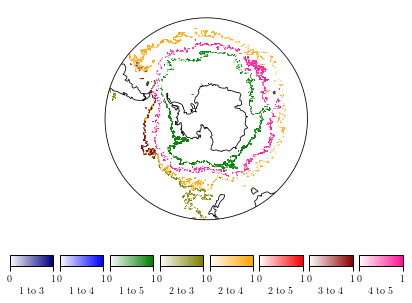

In [238]:
da  = run_through_plot(K=5)
plot_on_one(da.isel(time=0))
plt.savefig('../FBSO-Report/images/fig4-new.png', dpi=900, bbox_inches='tight')

running 40
[<matplotlib.colors.LinearSegmentedColormap object at 0x7f94e61d9bb0>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f98caacea90>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f98caace880>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f98caace730>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f98caacea60>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f98caace8e0>]


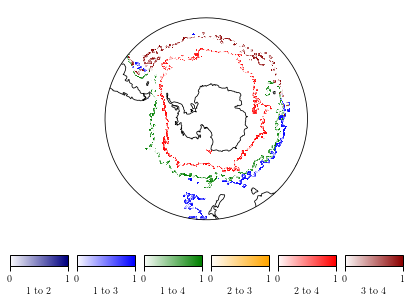

In [191]:
da  = run_through_plot(K=4)
plot_on_one(da.isel(time=0))

running 40


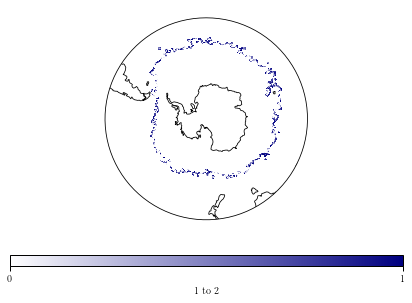

In [192]:
da  = run_through_plot(K=2)
plot_on_one(da.isel(time=0))

## Run Test B

In [161]:
# ds = xr.open_dataset("/Volumes/BSOSE-DISC/pyxpcm/nc/i-metric-joint-k-5-d-3.nc")
ds = xr.open_dataset("~/pyxpcm/nc/i-metric-joint-k-4-d-3.nc")

<Figure size 432x288 with 0 Axes>

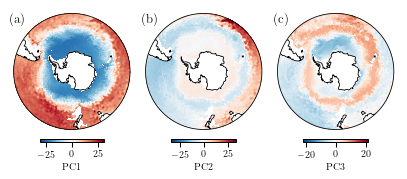

In [162]:
da_temp = ds.PCA_VALUES.isel(time=40)
sep_plots([da_temp.isel(pca=0), 
           da_temp.isel(pca=1), 
           da_temp.isel(pca=2)],
          ['PC1', 'PC2', 'PC3'])
plt.savefig('../FBSO-Report/images/fig1-new.png', dpi=900, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

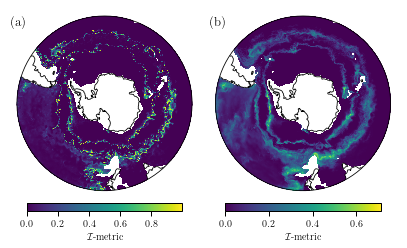

In [173]:
sep_plots([ds.IMETRIC.isel(Imetric=0, time=40), 
           ds.IMETRIC.isel(Imetric=0).mean(dim="time", skipna=True)],
          ['$\mathcal{I}$-metric ',
           '$\mathcal{I}$-metric'])
plt.savefig('../FBSO-Report/images/fig3-new.png', dpi=900, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

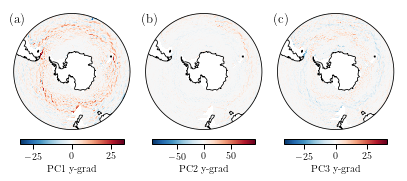

In [172]:
da_temp = ds.PCA_VALUES.isel(time=40).differentiate("YC") 
sep_plots([da_temp.isel(pca=0), 
           da_temp.isel(pca=1), 
           da_temp.isel(pca=2)],
          ['PC1 y-grad', 
           'PC2 y-grad', 
           'PC3 y-grad'])
plt.savefig('../FBSO-Report/images/fig6-new.png', dpi=900, bbox_inches='tight')

/Users/simon/anaconda3/envs/fronts4/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<Figure size 432x288 with 0 Axes>

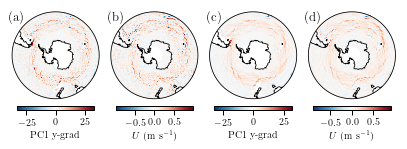

In [171]:
main_dir = "/Users/simon/fbso/fbso/bsose_monthly/"
uvel = main_dir + "bsose_i106_2008to2012_monthly_Uvel.nc"
uvel_ds = xr.open_dataset(uvel).isel(Z=15)
ds = xr.open_dataset("~/pyxpcm/nc/i-metric-joint-k-4-d-3.nc")

sep_plots(
    [
        ds.PCA_VALUES.isel(time=40, pca=0).differentiate("YC"),
        uvel_ds.UVEL.isel(time=40),
        ds.PCA_VALUES.isel(pca=0).differentiate("YC").mean(dim="time", skipna=True),
        uvel_ds.UVEL.mean(dim="time", skipna=True),
    ],
    ["PC1 y-grad", r"$U$ (m s$^{-1}$)", "PC1 y-grad", r"$U$ (m s$^{-1}$)"],
)

plt.savefig(
    "../FBSO-Report/images/compare-sobel-with-U.png", dpi=900, bbox_inches="tight"
)

## Take Correlation between Grad and Velocity

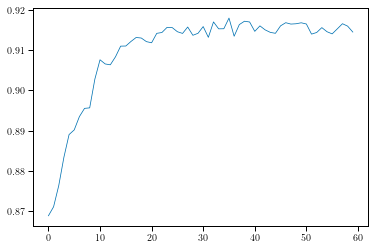

In [176]:
uvel_ds = xr.open_dataset(uvel).isel(Z=15)
pca_ds = (
    xr.open_dataset("~/pyxpcm/nc/i-metric-joint-k-4-d-3.nc")
    .isel(pca=0)
    .differentiate("YC")
)

cor_list = []

for time_i in range(0, 60):
    cor = ma.corrcoef(
        ma.masked_invalid(uvel_ds.isel(time=time_i).UVEL.values.ravel()),
        ma.masked_invalid(pca_ds.isel(time=time_i).PCA_VALUES.values.ravel()),
    )
    cor_list.append(cor[1, 0])

plt.plot(range(0, 60), cor_list)

Text(0.5, 1.0, 'Correlation between PC1 y-grad and $U$')

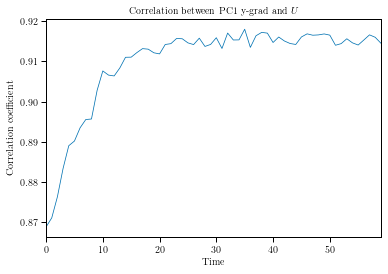

In [179]:
plt.plot(range(0, 60), cor_list)
plt.xlabel('Time')
plt.ylabel('Correlation coefficient')
plt.xlim([0, 59])
plt.title('Correlation between PC1 y-grad and $U$')

In [180]:
cor = ma.corrcoef(
        ma.masked_invalid(uvel_ds.mean(dim="time", skipna=True).UVEL.values.ravel()),
        ma.masked_invalid(pca_ds.mean(dim="time", skipna=True).PCA_VALUES.values.ravel()),
    )
print(cor)

/Users/simon/anaconda3/envs/fronts4/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[[1.0 0.9253345370338635]
 [0.9253345370338635 1.0]]


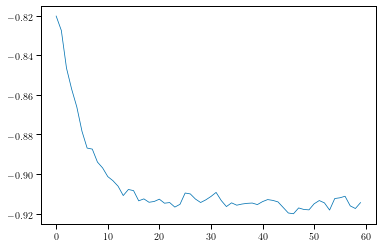

In [181]:
main_dir = "/Users/simon/fbso/fbso/bsose_monthly/"
vvel = main_dir + "bsose_i106_2008to2012_monthly_Vvel.nc"
vvel_ds = xr.open_dataset(vvel).isel(Z=15)
ds = xr.open_dataset("~/pyxpcm/nc/i-metric-joint-k-4-d-3.nc")
pca_ds = (
    xr.open_dataset("~/pyxpcm/nc/i-metric-joint-k-4-d-3.nc")
    .isel(pca=0)
    .differentiate("XC")
)

cor_list = []

for time_i in range(0, 60):
    cor = ma.corrcoef(
        ma.masked_invalid(vvel_ds.isel(time=time_i).VVEL.values.ravel()),
        ma.masked_invalid(pca_ds.isel(time=time_i).PCA_VALUES.values.ravel()),
    )
    cor_list.append(cor[1, 0])

plt.plot(range(0, 60), cor_list)

Text(0.5, 1.0, 'Correlation between PC1 x-grad and $V$')

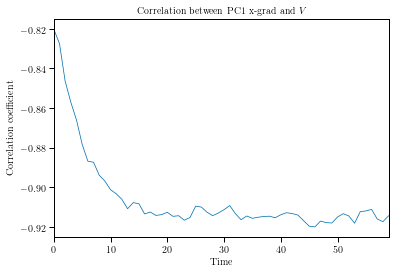

In [182]:
plt.plot(range(0, 60), cor_list)
plt.xlabel('Time')
plt.ylabel('Correlation coefficient')
plt.xlim([0, 59])
plt.title('Correlation between PC1 x-grad and $V$')

In [183]:
cor = ma.corrcoef(
        ma.masked_invalid(vvel_ds.mean(dim="time", skipna=True).VVEL.values.ravel()),
        ma.masked_invalid(pca_ds.mean(dim="time", skipna=True).PCA_VALUES.values.ravel()),
    )
print(cor)

/Users/simon/anaconda3/envs/fronts4/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[[1.0 -0.9104996023864581]
 [-0.9104996023864581 1.0]]


## Plot Several pair-I-metrics together

In [242]:
def plot_on_one_mult(da_list):

    carree = ccrs.PlateCarree()
    map_proj = ccrs.SouthPolarStereo()

    pairs_list = []
    width_ratios = []
    num_pairs = 0
    num_plots = len(da_list)

    for i in range(len(da_list)):
        if i != 0:
            width_ratios.append(0.05)
            num_pairs += 1
        num_pairs += da_list[i].coords["pair"].values.shape[0]
        pairs = da_list[i].coords["pair"].values
        pairs_list.append(pairs)
        for width in [1 / num_plots / len(pairs) for x in range(len(pairs))]:
            width_ratios.append(width)

    gs = GridSpec(
        nrows=2,
        ncols=num_pairs,
        width_ratios=width_ratios,
        height_ratios=[1, 0.05],
        wspace=0.15,
    )

    fig = plt.gcf()
    # fig.set_inches((5*num_plots, 5))
    fig.set_size_inches(5*num_plots + 0.2*num_plots, 5*1.2)

    used_up_columns = 0
    primary_axes_list = []

    for i in range(len(pairs_list)):
        print("trying fig", i)

        ax1 = fig.add_subplot(
            gs[0, used_up_columns : used_up_columns + pairs_list[i].shape[0]],
            projection=map_proj,
        )
        cbar_axes = [
            fig.add_subplot(gs[1, used_up_columns + j])
            for j in range(len(pairs_list[i]))
        ]

        used_up_columns += pairs_list[i].shape[0] + 1

        southern_ocean_axes_setup(ax1, fig)
        cmap_list = sps.return_list_of_colormaps(
            len(pairs_list[i]), fade_to_white=False
        )

        for j in range(len(pairs_list[i])):
            print("pair number", j)
            print("pair name", da_list[i].coords["pair"].values[j])

            im = (
                da_list[i]
                .isel(pair=j)
                .plot(
                    cmap=cmap_list[j],
                    vmin=0,
                    vmax=1,
                    ax=ax1,
                    add_colorbar=False,
                    transform=carree,
                    subplot_kws={"projection": map_proj},
                )
            )
            cbar = plt.colorbar(
                im,
                shrink=0.8,
                orientation="horizontal",  # xr_da.name
                pad=0.01,
                cax=cbar_axes[j],
                ticks=[0, 1],
            )
            cbar.set_label(da_list[i].coords["pair"].values[j])
        plt.suptitle("")
        plt.title("")
        ax1.set_title("")
        ax1.coastlines()
        primary_axes_list.append(ax1)

    label_subplots(primary_axes_list)

running 40
running 40
trying fig 0
pair number 0
pair name 1 to 2
trying fig 1
pair number 0
pair name 1 to 2
pair number 1
pair name 1 to 3
pair number 2
pair name 1 to 4
pair number 3
pair name 2 to 3
pair number 4
pair name 2 to 4
pair number 5
pair name 3 to 4


<ipython-input-243-ef16fa365c98>:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


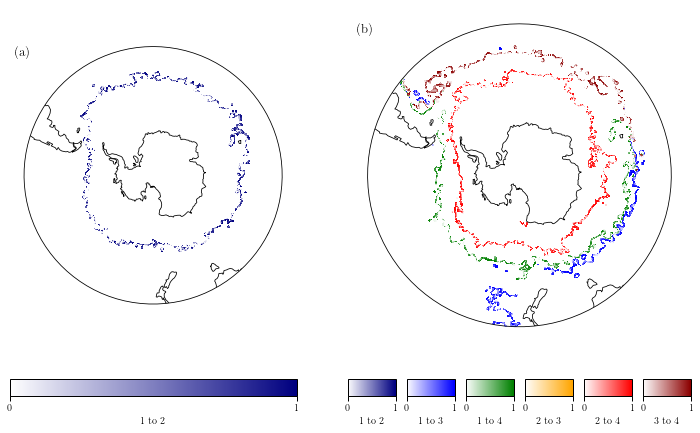

In [243]:
plot_on_one_mult([run_through_plot(K=2).isel(time=0, variable=0), 
                  run_through_plot(K=4).isel(time=0, variable=0)])
plt.tight_layout()
plt.savefig(
    "../FBSO-Report/images/fig5-new.png", dpi=900, bbox_inches="tight"
)

running 40
running 40
running 40
trying fig 0
pair number 0
pair name 1 to 2
trying fig 1
pair number 0
pair name 1 to 2
pair number 1
pair name 1 to 3
pair number 2
pair name 1 to 4
pair number 3
pair name 2 to 3
pair number 4
pair name 2 to 4
pair number 5
pair name 3 to 4
trying fig 2
pair number 0
pair name 1 to 3
pair number 1
pair name 1 to 4
pair number 2
pair name 1 to 5
pair number 3
pair name 2 to 3
pair number 4
pair name 2 to 4
pair number 5
pair name 2 to 5
pair number 6
pair name 3 to 4
pair number 7
pair name 4 to 5


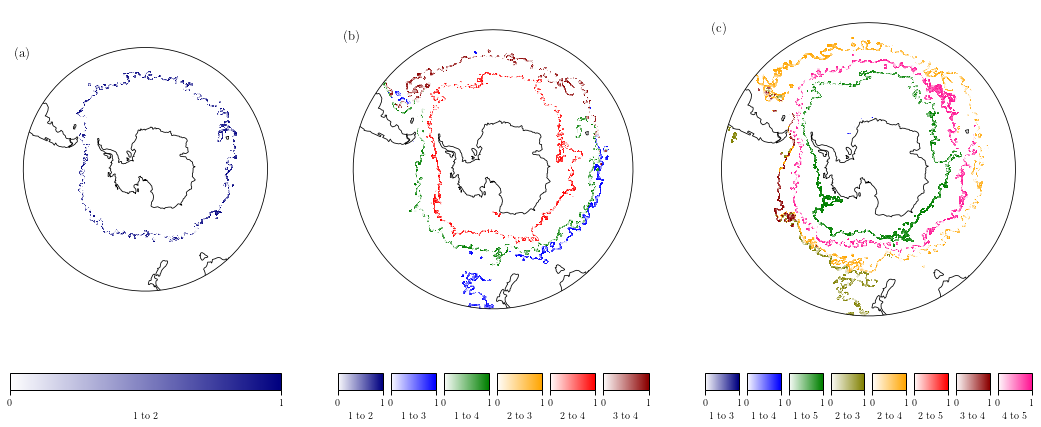

In [244]:
plot_on_one_mult([run_through_plot(K=2).isel(time=0, variable=0), 
                  run_through_plot(K=4).isel(time=0, variable=0),
                  run_through_plot(K=5).isel(time=0, variable=0)])


## Make Figure 2 - The Clusters in 2D

In [ ]:
m, ds = rtg.train_on_interpolated_year(time_i=42, K=5, maxvar=2, min_depth=300, 
                                       max_depth=2000, separate_pca=False)

In [10]:
def pair_i_metric(ds):

    sorted_version = np.sort(ds.A_B.values, axis=0)
    # (2, 12, 60, 240)
    # rank, time, YC, XC

    i_metric = ds.IMETRIC.isel(Imetric=0).values

    list_no = [i for i in range(int(np.nanmax(sorted_version)) + 1)]

    cart_prod = [
        np.array([a, b]) for a in list_no for b in list_no if a <= b and a != b
    ]

    pair_i_metric_list = []

    pair_list = []

    for pair in cart_prod:

        shape = np.shape(sorted_version)

        pair_i_metric = np.empty([shape[1], shape[2], shape[3]])
        pair_i_metric[:] = np.nan

        at_least_one_point = False

        for i in range(shape[1]):
            for j in range(shape[2]):
                for k in range(shape[3]):

                    if np.array_equal(pair, sorted_version[:, i, j, k]):
                        if i_metric[i, j, k] >= 0.3:

                            pair_i_metric[i, j, k] = i_metric[i, j, k]
                            at_least_one_point = True

        if at_least_one_point:

            pair_i_metric_list.append(pair_i_metric)
            pair_list.append(pair)

    print(pair_list)

    pair_i_metric_array = np.zeros(
        [len(pair_i_metric_list), shape[1], shape[2], shape[3]]
    )

    for i in range(len(pair_i_metric_list)):

        pair_i_metric_array[i, :, :, :] = pair_i_metric_list[i][:, :, :]

    pair_str_list = []

    for i in range(len(pair_list)):
        pair_str_list.append(
            str(pair_list[i][0] + 1) + " to " + str(pair_list[i][1] + 1)
        )

    da = xr.DataArray(
        pair_i_metric_array,
        dims=["pair", "time", "YC", "XC"],  ##
        coords={
            "XC": ds.coords["XC"].values,
            "YC": ds.coords["YC"].values,
            "time": ds.coords["time"].values,  ##
            "pair": pair_str_list,
        },
    )

    return da

In [251]:
def get_fig2a(ds):
    K = int(ds.PCM_LABELS.max().values.tolist()) + 1
    plt.scatter(
        ds.PCA_VALUES.isel(pca=0),
        ds.PCA_VALUES.isel(pca=1),
        c=ds.PCM_LABELS + 1,
        cmap=cm.get_cmap("Set1", K),  #'viridis_r',
        vmin=0.5,
        vmax=K + 0.5,
        alpha=0.5,
    )
    label_subplots([plt.gca()], start_from=0)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(
        label="Class Assignment", ticks=range(1, K + 1), orientation="horizontal"
    )
    plt.savefig(
        "../FBSO-Report/images/fig2a-2d-k-" + str(K) + "_.png",
        dpi=600,
        bbox_inches="tight",
    )

In [265]:
def run_i_metrics_with_ellipsoids_2d(ds):
    K = int(ds.PCM_LABELS.max().values.tolist()) + 1

    da = pair_i_metric(ds)

    pairs = da.coords["pair"].values.shape[0]

    cmap_list = sps.return_list_of_colormaps(pairs, fade_to_white=False)

    gs = GridSpec(
        nrows=2,
        ncols=pairs,
        width_ratios=[1 / pairs for x in range(pairs)],
        height_ratios=[1, 0.05],
    )

    fig = plt.gcf()

    ax1 = fig.add_subplot(gs[0, :])
    cbar_axes = [fig.add_subplot(gs[1, i]) for i in range(pairs)]

    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)

    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")

    for i in range(pairs):

        im = ax1.scatter(
            ds.PCA_VALUES.isel(pca=0),
            ds.PCA_VALUES.isel(pca=1),
            c=da.isel(pair=i),
            cmap=cmap_list[i],
            alpha=0.5,
        )

        cbar = plt.colorbar(
            im, cax=cbar_axes[i], orientation="horizontal", ticks=[0, 1]
        )

        cbar.set_label(da.coords["pair"].values[i])

    color_array = cm.get_cmap("Set1", K).colors
    
    for i in range(m._classifier.covariances_.shape[0]):
        weight = m._classifier.weights_[i]
        mean = m._classifier.means_[i]

        U, s, rotation = la.svd(m._classifier.covariances_[i])
        for frac_sigma, alpha in [
            [1 / 9, 0.5 * weight],
            [1 / 4, 0.7 * weight],
            [1, weight],
        ]:

            def print_constants():
                print(frac_sigma, alpha)
                print("U", U)
                print("s", s)
                print("rot", rotation)

            radii = np.sqrt(s / frac_sigma)
            # plt.plot(m._classifier.means_[:, 0], m._classifier.means_[:, 1], "x")
            angle = np.arctan2(rotation[1, 0], rotation[0, 0]) / np.pi * 180

            e1 = patch.Ellipse(
                mean,
                radii[0],
                radii[1],
                angle=angle,
                alpha=alpha,
                color=color_array[i]
            )
            ax1.add_patch(e1)
            label_subplots([ax1], start_from=1)

    plt.tight_layout()
    plt.savefig("../FBSO-Report/images/fig2-k-" + str(K) + "_.pdf", bbox_inches="tight")
    plt.savefig("../FBSO-Report/images/fig2-k-" + str(K) + "_.png", dpi=600, bbox_inches="tight")

  fit.1-preprocess.1-mask: 50 ms
features_dict {'THETA': 'THETA', 'SALT': 'SALT'}
  fit.1-preprocess.2-feature_THETA.1-ravel: 261 ms
  fit.1-preprocess.2-feature_THETA.2-interp: 4 ms
  fit.1-preprocess.2-feature_THETA.3-scale_fit: 1431 ms
  fit.1-preprocess.2-feature_THETA.4-scale_transform: 969 ms
  fit.1-preprocess.2-feature_THETA.total: 2667 ms
  fit.1-preprocess.2-feature_SALT.1-ravel: 232 ms
  fit.1-preprocess.2-feature_SALT.2-interp: 4 ms
  fit.1-preprocess.2-feature_SALT.3-scale_fit: 1362 ms
  fit.1-preprocess.2-feature_SALT.4-scale_transform: 997 ms
  fit.1-preprocess.2-feature_SALT.total: 2597 ms
  fit.1-preprocess.2-feature_all.5-join: 179 ms
Fitting PCA
  fit.1-preprocess.2-feature_all.6-reduce_fit: 4254 ms
  fit.1-preprocess.2-feature_all.7-reduce_transform: 929 ms
  fit.1-preprocess.4-xarray: 20 ms
  fit.1-preprocess: 10722 ms
  fit.fit: 2233 ms
  fit.reorder: 0 ms
  fit.score: 35 ms
  fit: 12992 ms
  fit.1-preprocess.1-mask: 178 ms
features_dict {'THETA': 'THETA', 'SALT':

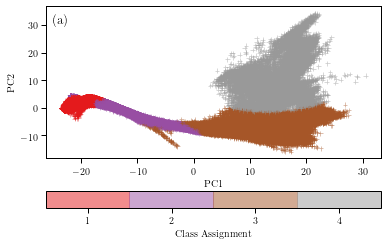

[array([0, 1]), array([1, 2]), array([2, 3])]


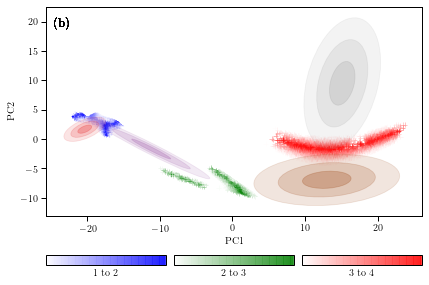

  fit.1-preprocess.1-mask: 40 ms
features_dict {'THETA': 'THETA', 'SALT': 'SALT'}
  fit.1-preprocess.2-feature_THETA.1-ravel: 249 ms
  fit.1-preprocess.2-feature_THETA.2-interp: 4 ms
  fit.1-preprocess.2-feature_THETA.3-scale_fit: 1361 ms
  fit.1-preprocess.2-feature_THETA.4-scale_transform: 967 ms
  fit.1-preprocess.2-feature_THETA.total: 2583 ms
  fit.1-preprocess.2-feature_SALT.1-ravel: 246 ms
  fit.1-preprocess.2-feature_SALT.2-interp: 4 ms
  fit.1-preprocess.2-feature_SALT.3-scale_fit: 1350 ms
  fit.1-preprocess.2-feature_SALT.4-scale_transform: 976 ms
  fit.1-preprocess.2-feature_SALT.total: 2579 ms
  fit.1-preprocess.2-feature_all.5-join: 175 ms
Fitting PCA
  fit.1-preprocess.2-feature_all.6-reduce_fit: 4467 ms
  fit.1-preprocess.2-feature_all.7-reduce_transform: 627 ms
  fit.1-preprocess.4-xarray: 20 ms
  fit.1-preprocess: 10519 ms
  fit.fit: 12740 ms
  fit.reorder: 0 ms
  fit.score: 43 ms
  fit: 23305 ms
  fit.1-preprocess.1-mask: 77 ms
features_dict {'THETA': 'THETA', 'SALT':

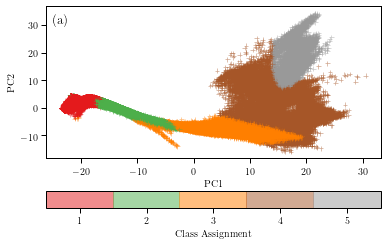

[array([0, 1]), array([0, 2]), array([1, 2]), array([2, 3]), array([3, 4])]


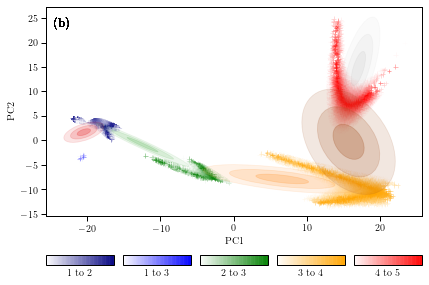

In [266]:
for K in [4, 5]:
    m, ds = rtg.train_on_interpolated_year(time_i=42, K=K, maxvar=2, min_depth=300, 
                                           max_depth=2000, separate_pca=False)
    get_fig2a(ds)
    plt.show()
    run_i_metrics_with_ellipsoids_2d(ds)
    plt.show()

## Make Figure 2 - The Clusters in 3D

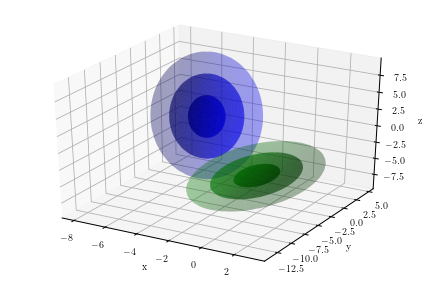

In [102]:
def plot_ellipsoid_trial():
    """
    https://stackoverflow.com/questions/7819498/plotting-ellipsoid-with-matplotlib

    :return:
    """

    # your ellipsoid's covariance_matrix and mean in matrix form
    covariance_matrix = np.array([[1, 0.5, 0], [0.2, 2, 0], [0, 0, 10]])
    covariance_matrix1 = np.array([[1, 0.1, 0], [0.2, 8, 0], [0, 0, 1]])

    mean = [-5, 0.3, 0.1]
    mean1 = [0, -5, -4]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    fig = plot_ellipsoid(fig, ax, covariance_matrix, mean, 1, "b")
    plot_ellipsoid(fig, ax, covariance_matrix1, mean1, 1, "g")
    plt.xlabel("x")
    plt.ylabel("y")
    # plt.zlabel('z')
    ax.set_zlabel('z')
    plt.tight_layout()
    plt.show()


def plot_ellipsoid(
    fig,
    ax,
    covariance_matrix,
    mean,
    weight,
    color,
    print_properties=False,
    additional_rotation=np.identity(3),
):
    """
    A function for drawing 3d-multivariate guassians with method initially from:
    https://stackoverflow.com/questions/7819498/plotting-ellipsoid-with-matplotlib

    :param fig: The figure matplotlib.pyplot object
    :param ax: The axis matplotlib.pylot object with Axes3D extension
    :param covariance_matrix: A covariance matrix input from the multivariate guassian to be plotted
    :param mean: ditto
    :param weight: ditto
    :param color: ditto
    :return: fig and ax so that they can be used by further plotting steps.
    """

    # I arbitrarily choose some levels to in the multivariate Gaussian to plot.

    if print_properties == True:
        print("weight", weight)
        print("mean", mean)
        print("covariance matrix", covariance_matrix)

    for sigma, alpha in [
        [3, 0.2 * weight],
        [2, 0.4 * weight],
        [1, 0.6 * weight],
    ]:
        # find the rotation matrix and radii of the axes
        U, s, rotation = la.svd(covariance_matrix)
        # Singular Value Decomposition from numpy.linalg finds the variance vector s when the covariance
        # matrix has been rotated so that it is diagonal
        radii = np.sqrt(s) * sigma
        # s is the sigma*2 in each of the principal axes directions

        # now carry on with EOL's answer
        u = np.linspace(0.0, 2.0 * np.pi, 100)  # AZIMUTHAL ANGLE (LONGITUDE)
        v = np.linspace(0.0, np.pi, 100)  # POLAR ANGLE (LATITUDE)

        # COORDINATES OF THE SURFACE PRETENDING THAT THE GAUSSIAN IS AT THE CENTRE & NON ROTATED
        x = radii[0] * np.outer(np.cos(u), np.sin(v))  # MESH FOR X
        y = radii[1] * np.outer(np.sin(u), np.sin(v))  # MESH FOR Y
        z = radii[2] * np.outer(np.ones_like(u), np.cos(v))  # MESH FOR Z

        # move so that the gaussian is actually rotated and on the right point.
        for i in range(len(x)):
            for j in range(len(x)):
                [x[i, j], y[i, j], z[i, j]] = (
                    np.dot([x[i, j], y[i, j], z[i, j]], rotation) + mean
                )
                [x[i, j], y[i, j], z[i, j]] = np.dot(
                    additional_rotation, [x[i, j], y[i, j], z[i, j]]
                )
        # plot the surface in a reasonable partially translucent way
        ax.plot_surface(x, y, z, rstride=4, cstride=4, color=color, alpha=alpha)
    return fig, ax


plot_ellipsoid_trial()

In [11]:
def plot_fig2_3d(weights, means, covariances, ds):
    """
    https://stackoverflow.com/questions/7819498/plotting-ellipsoid-with-matplotlib
    :return:
    """
    assert (
        np.shape(means)[0] == np.shape(weights)[0]
        and np.shape(weights)[0] == np.shape(covariances)[0]
    )

    number_clusters = np.shape(means)[0]

    colors = cm.get_cmap("Set1", number_clusters).colors
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    
    for i in range(number_clusters):
        fig, ax = plot_ellipsoid(fig, ax, covariances[i], means[i], weights[i], colors[i])

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    ax.set_zlabel("PC3")
    plt.tight_layout()
    return ax

In [6]:
m, ds = rtg.train_on_interpolated_year(time_i=42, K=5, maxvar=3, min_depth=300, 
                                       max_depth=2000, separate_pca=False)
print(m._classifier.weights_, '\n\n\n',  m._classifier.means_, '\n\n\n',  m._classifier.covariances_)

  fit.1-preprocess.1-mask: 91 ms
features_dict {'THETA': 'THETA', 'SALT': 'SALT'}
  fit.1-preprocess.2-feature_THETA.1-ravel: 335 ms
  fit.1-preprocess.2-feature_THETA.2-interp: 13 ms
  fit.1-preprocess.2-feature_THETA.3-scale_fit: 1907 ms
  fit.1-preprocess.2-feature_THETA.4-scale_transform: 1025 ms
  fit.1-preprocess.2-feature_THETA.total: 3282 ms
  fit.1-preprocess.2-feature_SALT.1-ravel: 284 ms
  fit.1-preprocess.2-feature_SALT.2-interp: 4 ms
  fit.1-preprocess.2-feature_SALT.3-scale_fit: 1919 ms
  fit.1-preprocess.2-feature_SALT.4-scale_transform: 1050 ms
  fit.1-preprocess.2-feature_SALT.total: 3259 ms
  fit.1-preprocess.2-feature_all.5-join: 235 ms
Fitting PCA
  fit.1-preprocess.2-feature_all.6-reduce_fit: 4005 ms
  fit.1-preprocess.2-feature_all.7-reduce_transform: 494 ms
  fit.1-preprocess.4-xarray: 21 ms
  fit.1-preprocess: 11425 ms
  fit.fit: 6393 ms
  fit.reorder: 0 ms
  fit.score: 44 ms
  fit: 17864 ms
  fit.1-preprocess.1-mask: 73 ms
features_dict {'THETA': 'THETA', 'SALT

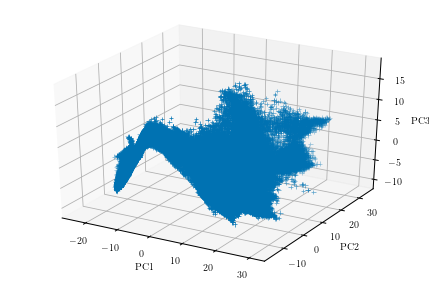

NameError: name 'plot_fig2_3d' is not defined

In [7]:
PCS = ds.PCA_VALUES
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(PCS.isel(pca=0).values.ravel(), 
           PCS.isel(pca=1).values.ravel(), 
           PCS.isel(pca=2).values.ravel())
plt.xlabel("PC1")
plt.ylabel("PC2")
ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()

ax =  plot_fig2_3d(m._classifier.weights_, 
                   m._classifier.means_,
                   m._classifier.covariances_, 
                   ds)

plt.tight_layout()
plt.show()

## Combined  Multiple Plots for Figure 3 

In [ ]:
def plot_fig2_mult(weights, means, covariances, ds):
    """
    This will hopefully plot fig2a and fig2b with automatic labelling.
    """
    
    da = pair_i_metric(ds)

    carree = ccrs.PlateCarree()
    map_proj = ccrs.SouthPolarStereo()

    pairs_list = []
    width_ratios = []
    num_pairs = 0
    num_plots = 2

    for i in range(num_plots):
        if i == 0:
            num_pairs += 1
            pairs = np.asarray([i for i in range(1)])
            width_ratios.append(0.5)
            pairs_list.append(pairs)
        elif i == 1:
            width_ratios.append(0.05)
            num_pairs += 1
            pairs = da.coords["pair"].values
            cmap_list = sps.return_list_of_colormaps(len(pairs), fade_to_white=False)
            pairs_list.append(pairs)
            for width in [1 / num_plots / len(pairs) for x in range(len(pairs))]:
                width_ratios.append(width)
        
        print(pairs_list)
        print(width_ratios)

    gs = GridSpec(
                 nrows=2,
                 ncols=len(width_ratios),
                 width_ratios=width_ratios,
                 height_ratios=[1, 0.05],
                 wspace=0.15,
            )

    fig = plt.gcf()
    # fig.set_inches((5*num_plots, 5))
    fig.set_size_inches(5 * num_plots + 0.2 * num_plots, 5 * 1.2)
    
    used_up_columns = 0
    primary_axes_list = []

    for i in range(2):
        print("trying fig", i)
        
        if i == 0:
            ax1 = fig.add_subplot(
                gs[0, 0],
                projection="3d",
            )        
            cbar_ax = fig.add_subplot(gs[1, 0])
            used_up_columns += 2
        elif i == 1:
            print('used_up_columns', used_up_columns)
            print('used_up_columns + pairs_list[i].shape[0]', used_up_columns + pairs_list[i].shape[0])
            ax1 = fig.add_subplot(
                gs[0, used_up_columns : 
                   used_up_columns 
                   + pairs_list[i].shape[0]],
                projection="3d",
            )

            cbar_axes = [
                fig.add_subplot(gs[1, used_up_columns + j])
                for j in range(len(pairs_list[i]))
            ]

            used_up_columns += pairs_list[i].shape[0] + 1


        #cmap_list = sps.return_list_of_colormaps(
        #    len(pairs_list[i]), fade_to_white=False
        #)
        if i == 0:
            
            PCS = ds.PCA_VALUES
            im = ax1.scatter(PCS.isel(pca=0).values.ravel(),
                        PCS.isel(pca=1).values.ravel(),
                        PCS.isel(pca=2).values.ravel(),
                        cmap=cm.get_cmap("Set1", len(weights)),
                        c=ds.PCM_LABELS.values.ravel() + 1,
                        vmin=0.5,
                        vmax=len(weights) + 0.5,
                        alpha=0.5,
                        )

            plt.colorbar(im, cax=cbar_ax,
                label="Class Assignment", ticks=range(1, len(weights) + 1), orientation="horizontal"
                )
            ax1.set_xlabel("PC1")
            ax1.set_ylabel("PC2")
            ax1.set_zlabel("PC3")
            primary_axes_list.append(ax1)

            
        if i == 1:
            
            number_clusters = np.shape(means)[0]

            colors = cm.get_cmap("Set1", number_clusters).colors
            
            fig = plt.gcf()
    
            for j in range(number_clusters):
                fig, ax1 = plot_ellipsoid(fig, ax1, covariances[j], means[j], weights[j], colors[j])
                

            for j in range(len(pairs_list[i])):

                im = ax1.scatter(
                    ds.PCA_VALUES.isel(pca=0).values.ravel(),
                    ds.PCA_VALUES.isel(pca=1).values.ravel(),
                    ds.PCA_VALUES.isel(pca=2).values.ravel(),
                    c=da.isel(pair=j).values.ravel(),
                    cmap=cmap_list[j],
                    alpha=0.5,
                )

                cbar = plt.colorbar(
                    im, cax=cbar_axes[j], orientation="horizontal", ticks=[0, 1]
                )

                cbar.set_label(da.coords["pair"].values[j])

            """
            for j in range(len(pairs_list[i])):
                print("pair number", j)
                print("pair name", pairs_list[i][j])
                im = (
                    da
                    .isel(pair=j)
                    .plot(
                        cmap=cmap_list[j],
                        vmin=0,
                        vmax=1,
                        ax=ax1,
                        add_colorbar=False,
                        transform=carree,
                        subplot_kws={"projection": map_proj},
                    )
                )
                cbar = plt.colorbar(
                    im,
                    shrink=0.8,
                    orientation="horizontal",  # xr_da.name
                    pad=0.01,
                    cax=cbar_axes[j],
                    ticks=[0, 1],
                )
                cbar.set_label(da_list[i].coords["pair"].values[j])
            """
            plt.suptitle("")
            plt.title("")
            ax1.set_title("")
            primary_axes_list.append(ax1)
            ax1.set_xlabel("PC1")
            ax1.set_ylabel("PC2")
            ax1.set_zlabel("PC3")
    
    # plt.tight_layout()
    # label_subplots(primary_axes_list)
    plt.savefig('../FBSO-Report/images/fig2-3d.png', bbox_inches='tight', dpi=700)

In [ ]:
plot_fig2_mult(m._classifier.weights_, 
               m._classifier.means_,
               m._classifier.covariances_, 
               ds)

In [130]:
dir(ds)

['A_B',
 'IMETRIC',
 'Imetric',
 'PCA_VALUES',
 'PCM_LABELS',
 'XC',
 'YC',
 'Z',
 '_HANDLED_TYPES',
 '__abs__',
 '__abstractmethods__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__copy__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_layers__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__dask_tokenize__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__div__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__